# import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import time
import pickle
from sklearn.preprocessing import MinMaxScaler

In [7]:
current_dir = os.getcwd()
file_dir=os.path.join(current_dir, "import_data\EV_data.xlsx")  # file dir
df_import = pd.read_excel(file_dir, index_col=0, sheet_name=None)
df_import

# global function

In [ ]:
def moving_avg(dataframe, n=10, skip='PS', random_state=42):
    df = dataframe.copy(deep=True)
    df['type'] = [i.split('_')[0] for i in df.index] 
    temp=pd.DataFrame()
    if skip != None:
        temp = df.query('type == @skip').copy(deep=True)       
    df_drop = df.drop(index=df[df['type']=='PS'].index)
    df_moving_avg = pd.DataFrame()
    for i in df_drop['type'].unique():
        df_i = df_drop.query('type == @i').drop(columns=['type'])
        df_i_shuffle = df_i.sample(frac=1, random_state=random_state, 
                                   axis=0) #randomly take frac% from all; axis=0, row;
        j=0
        while j+n <= len(df_i_shuffle):
            df_mean = pd.DataFrame(df_i_shuffle.iloc[j:j+n,:].mean()).T
            df_mean['type'] = i
            df_moving_avg = pd.concat([df_moving_avg, df_mean])
            j += 1
    df_moving_avg = pd.concat([df_moving_avg, temp])
    return df_moving_avg

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
def split_train_test(dataframe, y_col='type_num', split_y=False, cut=['type_num','type'], test_size=0.25, random_state=42):
    'split_trainset_&_test_set'
    split = StratifiedShuffleSplit(test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(dataframe, dataframe[y_col]):
        train_set = dataframe.iloc[train_index]
        test_set = dataframe.iloc[test_index]
    if split_y == True:
        df_train_x, df_train_y = num_cut(train_set, cut)
        df_test_x, df_test_y = num_cut(test_set, cut)
        return df_train_x, df_train_y[y_col], df_test_x, df_test_y[y_col]
    elif split_y == False:
        return train_set, test_set

def num_cut(dataframe, columns):
    'split_number_&_str_type'
    data_cat = dataframe.loc[:, columns]
    data_num = dataframe.drop(columns=columns)
    return data_num, data_cat

In [ ]:
def conf_mat_heatmap(conf_mat, rect_set, title, ticklabel=['A549','MCF10A','MCF7','PS'], cmap=None, mask=None):
    fig = plt.figure(dpi=130, figsize=(2.5,2.5)) 
    ax1 = fig.add_subplot(111)
    density_mat = conf_mat/np.sum(conf_mat, axis=1).reshape(conf_mat.shape[0], -1)
    if cmap == None:
        cmap = sns.cubehelix_palette(rot=0.2, gamma=0.5, dark=0.3, light=1, as_cmap=True)#return matplotlib colormap
    elif cmap == '5imp':
        cmap = LinearSegmentedColormap.from_list(name='cmap', colors=['w','orange'])
    if mask == True:
        mask=np.array(density_mat==0)
    h = sns.heatmap(data=density_mat, xticklabels=ticklabel, yticklabels=ticklabel, annot = True, 
                    fmt=".1%", linewidths=1, linecolor="0.7", cbar=False, #turn off color bar
                    annot_kws={'size':10,'weight':600,'family':"Arial",'color':"k"}, 
                    square=True, vmin=0, vmax=1, cmap=cmap, ax=ax1, mask=mask)
    ax1.tick_params(width=2, length=4, colors="k")
    rect = plt.Rectangle(xy=rect_set["xy1"], width=rect_set["width1"], height=rect_set["height1"],
                         fill=False, edgecolor="k", linewidth=rect_set["linewidth1"])
    ax1.add_patch(rect)
    # color bar
    rect_cb = [1, 0.13, 0.11, 0.74]
    cbar_ax = fig.add_axes(rect_cb)
    cb = h.figure.colorbar(h.collections[0], cax=cbar_ax) #show colorbar
    cb.ax.tick_params(direction='in', labelsize=10, length=4, width=1, colors="k",
                      left=True, right=True)
    rect2 = plt.Rectangle(xy=rect_set["xy2"], width=rect_set["width2"], height=rect_set["height2"],
                         fill=False, edgecolor="k", linewidth=rect_set["linewidth2"] )
    cbar_ax.add_patch( rect2 )
    # title
    font1 = {'family':'Arial', 'color':'k', 'weight':'bold', 'size': 12}
    accu = conf_mat.trace()/conf_mat.sum()
    ax1.set_xlabel('Accuracy Score:{:.1%}'.format(accu), font1);
    ax1.set_ylabel("Actual", font1); 
    ax1.set_title(str(title)+'\n Predicted', font1);  
rect_set2={"xy1":(0.023,0.017), "width1":2.94, "height1":2.96,"linewidth1":2.2,
                    "xy2":(0.03,0.004), "width2":0.97, "height2":0.99,"linewidth2":1.1}
rect_set3={"xy1":(0.03,0.017), "width1":3.94, "height1":3.96,"linewidth1":1.5,
                    "xy2":(0.03,0.002), "width2":0.97, "height2":1,"linewidth2":1.1}

# moving_average with RF

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

def ML_result(ML, X, y, X_test, y_test):
    "input: ML algorithm. autofit, then output confusion_matrix & accuracy."
    ML.fit(X, y) #fit
    #train
    y_pred = cross_val_predict(ML, X, y, cv=3)
    confmat_train = confusion_matrix(y, y_pred)
    accu_train = accuracy_score(y, y_pred)
    impo = ML.feature_importances_
    impo_df = pd.DataFrame(sorted(zip(impo, X.columns), reverse=True)) 
    #test
    final_pred = ML.predict(X_test)
    confmat_test = confusion_matrix(y_test, final_pred) 
    accu_test = accuracy_score(y_test, final_pred)
    return {"confmat_train":confmat_train, "accu_train":accu_train, 
            'confmat_test':confmat_test, "accu_test":accu_test, 'feature_importance':impo_df}

In [ ]:
from sklearn.preprocessing import MinMaxScaler
type_2_num={'A549':0, 'MCF10A':1, 'MCF7':2, 'PS':3}
def find_best_n(data_dict, n_range, skip_mov='PS', skip_norm='5imp', random_state=42):
    'moving average, then normalize'
    accu_train = pd.DataFrame(np.zeros([len(n_range),len(data_dict)]), index = n_range, 
                              columns = data_dict.keys()) #empty, accuracy of train set
    accu_test = pd.DataFrame(np.zeros([len(n_range),len(data_dict)]), index = n_range, 
                              columns = data_dict.keys()) #accuracy of test set
    result = {}
    for key in data_dict:
        result_n = []
        for n in n_range:
            data_mov = moving_avg(data_dict[key], n=n, skip=skip_mov, random_state=random_state)
            data_mov['type_num'] = [type_2_num[i] for i in data_mov['type']]
            if key != skip_norm:
                temp = data_mov.loc[:,['type_num','type']].copy(deep=True)
                df_drop = data_mov.drop(columns=['type_num','type'])
                df_normalized = MinMaxScaler((0,1)).fit_transform(df_drop)
                df_processed = pd.DataFrame(df_normalized, columns=df_drop.columns, index=df_drop.index)
                df_avg_norm = pd.concat([df_processed, temp], axis=1)
            else:
                df_avg_norm = data_mov.copy(deep=True)
            df_train_x, df_train_y, df_test_x, df_test_y = split_train_test(df_avg_norm, y_col='type_num', split_y=True)
            forest_clf = RandomForestClassifier(n_jobs=-1, random_state=random_state, n_estimators=100)
            clf_result = ML_result(forest_clf, df_train_x, df_train_y, df_test_x, df_test_y)
            result_n += [clf_result]
            accu_train.loc[n, key] = clf_result["accu_train"]
            accu_test.loc[n, key] = clf_result["accu_test"]
        result[key] = result_n
    return result, accu_train, accu_test

In [767]:
result_rf, accu_train_rf, accu_test_rf = find_best_n(df_import, n_range=range(1,21))

current_dir = os.getcwd()
root_dir=os.path.join(current_dir, "export_data\moving_avg_RF")
run_id = time.strftime("%Y_%m_%d_%H_%M_%S_")
accu_train_rf.to_excel(os.path.join(root_dir, run_id+'accu_train.xlsx'))
accu_test_rf.to_excel(os.path.join(root_dir, run_id+'accu_test.xlsx'))
with open(os.path.join(root_dir, run_id+'result.pickle'), 'wb') as f:
    pickle.dump(result_rf, f)

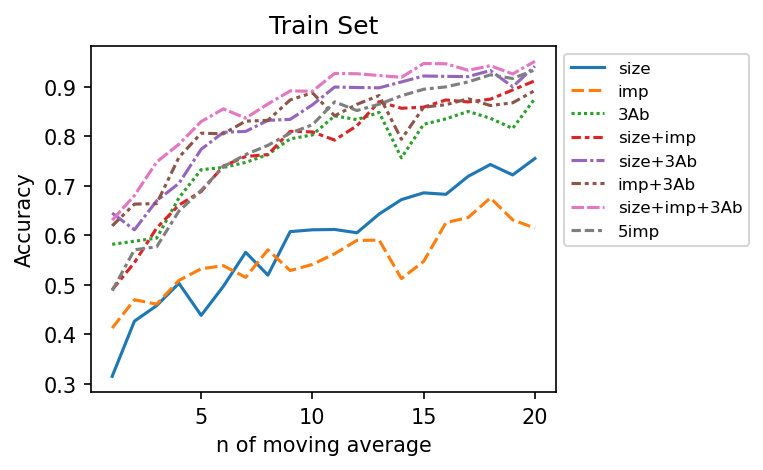

In [769]:
fig, ax1 = plt.subplots(figsize=(4,3), dpi=150)
sns.lineplot(accu_train_rf)
ax1.set_ylabel('Accuracy',) 
ax1.set_xlabel('n of moving average',)
#plt.ylim([0.3,1.05])
plt.title('Train Set');
plt.legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=8, frameon=True, ncol=1)

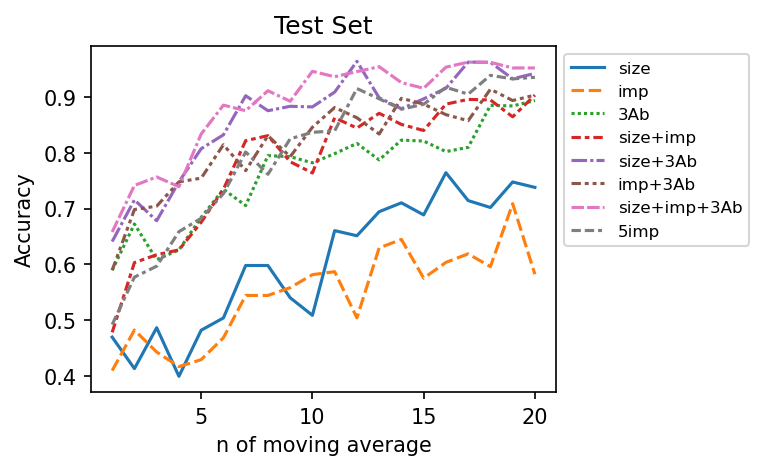

In [770]:
fig, ax1 = plt.subplots(figsize=(4,3), dpi=150)
sns.lineplot(accu_test_rf)
ax1.set_ylabel('Accuracy',)
ax1.set_xlabel('n of moving average',)
#plt.ylim([0.3,1.05])
plt.title('Test Set');
plt.legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=8, frameon=True, ncol=1)

## export_data

In [4]:
def export_data(result, root_dir, n=10, impo=False, tick_label=['A549','MCF10A','MCF7','PS'], 
                file_name='confmat.xlsx',):
    train_file_path = os.path.join(root_dir, 'train_'+file_name)
    test_file_path = os.path.join(root_dir, 'test_'+file_name)
    impo_file_path = os.path.join(root_dir, 'impo.xlsx')
    empty = pd.DataFrame()
    with pd.ExcelWriter(train_file_path, mode='w', engine='openpyxl') as writer:
        empty.to_excel(writer, sheet_name='sheet1')
    with pd.ExcelWriter(test_file_path, mode='w', engine='openpyxl') as writer:
        empty.to_excel(writer, sheet_name='sheet1')
    for key in result:
        with pd.ExcelWriter(train_file_path, mode='a', engine='openpyxl') as writer:
            confmat_train = pd.DataFrame(result[key][n-1]['confmat_train'], columns=tick_label, index=tick_label)
            confmat_train.to_excel(writer, sheet_name=key)
        
        with pd.ExcelWriter(test_file_path, mode='a', engine='openpyxl') as writer:
            confmat_test = pd.DataFrame(result[key][n-1]['confmat_test'], columns=tick_label, index=tick_label)
            confmat_test.to_excel(writer, sheet_name=key)
    if impo ==True:
        with pd.ExcelWriter(impo_file_path, mode='w', engine='openpyxl') as writer:
            result['size+imp+3Ab'][n-1]['feature_importance'].to_excel(writer, sheet_name='size+imp+3Ab')
            result['5imp'][n-1]['feature_importance'].to_excel(writer, sheet_name='5imp')

In [772]:
#export confmat
root_dir=os.path.join(current_dir, "export_data\moving_avg_RF")
run_id = time.strftime("%Y_%m_%d_%H_%M_%S")
export_data(result_rf, root_dir=root_dir, n=10, impo=True, file_name='confmat_'+run_id+'.xlsx')

In [853]:
#export moving avg
name=['size+imp+3Ab', 'size+imp', 'size+3Ab', 'imp+3Ab', 'size', 'imp', '3Ab', '5imp']
ex_dir=os.path.join(current_dir, "export_data\moving_avg_export_data")
for item in name:
    data_mov = moving_avg(df_import[item], n=10, skip='PS', random_state=42)
    data_mov['type_num'] = [type_2_num[i] for i in data_mov['type']]
    temp = data_mov.loc[:,['type_num','type']].copy(deep=True)
    df_drop = data_mov.drop(columns=['type_num','type'])
    df_normalized = MinMaxScaler((0,1)).fit_transform(df_drop)
    df_processed = pd.DataFrame(df_normalized, columns=df_drop.columns, index=df_drop.index)
    df_avg_norm = pd.concat([df_processed, temp], axis=1)
    df_avg_norm.to_excel(os.path.join(ex_dir,item+'_n=10.xlsx'))

## plot

In [774]:
item_list = {'Training Set':'confmat_train', 'Test Set':'confmat_test'}
def draw_selected_confmat(result, n=10, name=['Training Set'], impo=False, rect_set=rect_set3, cmap=None,
                          tick_label=['A549','MCF10A','MCF7','PS']):  
    for key in result:
        for item in name:
            conf_mat_heatmap(result[key][n-1][item_list[item]], rect_set=rect_set, cmap=cmap,
                             title=item, ticklabel=tick_label)
        if impo==True:
            draw_impo(result[key][n-1]['feature_importance'], cmap=cmap)

In [775]:
from matplotlib.colors import LinearSegmentedColormap
impo_label={'CD63_contrast_change':'CD63','Size/nm':'Size', 'Imp_contrast_change':'Impedance',
            'CD81_contrast_change':'CD81', 'EpCAM_contrast_change':'EpCAM'}
def draw_impo(impo_df, cmap=None):
    fig, ax1 = plt.subplots(figsize=(4,3), dpi=150)
    if cmap == None:
        cmap = sns.cubehelix_palette(rot=0.2, gamma=0.5, dark=0.3, light=1, n_colors=10, reverse=True)
    elif cmap == '5imp':
        cmap = LinearSegmentedColormap.from_list(name='cmap',colors=['orange','w'], N=10)(range(10))
    ax1.bar(x=impo_df[1], height=impo_df[0], width=0.4, color=cmap,)#edgecolor='coral'
    ax1.set_ylabel('Relative Importance')
    ax1.set_xlabel('Attribution')
    if ax1.get_xticklabels()[0].get_text() != '45Hz':
        curr_label = [impo_label[item.get_text()] for item in ax1.get_xticklabels()]
        ax1.set_xticklabels(curr_label, rotation=0, fontsize=10)

In [ ]:
data_mov = moving_avg(df_import['size+imp+3Ab'], n=10, skip='PS', random_state=42)
data_mov['type_num'] = [type_2_num[i] for i in data_mov['type']]
temp = data_mov.loc[:,['type_num','type']].copy(deep=True)
df_drop = data_mov.drop(columns=['type_num','type'])
df_normalized = MinMaxScaler((0,1)).fit_transform(df_drop)
df_processed = pd.DataFrame(df_normalized, columns=df_drop.columns, index=df_drop.index)
df_avg_norm = pd.concat([df_processed, temp], axis=1)
df_train_x, df_train_y, df_test_x, df_test_y = split_train_test(df_avg_norm, y_col='type_num', split_y=True)

forest_clf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=100)
#clf_result = ML_result(forest_clf, df_train_x, df_train_y, df_test_x, df_test_y)
forest_clf.fit(df_train_x, df_train_y) #fit

#train
y_pred = cross_val_predict(forest_clf, df_train_x, df_train_y, cv=3)
confmat_train = confusion_matrix(df_train_y, y_pred)
accu_train = accuracy_score(df_train_y, y_pred)
impo = forest_clf.feature_importances_
impo_df = pd.DataFrame(sorted(zip(impo, df_train_x.columns), reverse=True)) 

#test
final_pred = forest_clf.predict(df_test_x)
confmat_test = confusion_matrix(df_test_y, final_pred) 
accu_test = accuracy_score(df_test_y, final_pred)
clf_result = {"confmat_train":confmat_train, "accu_train":accu_train, 
                'confmat_test':confmat_test, "accu_test":accu_test, 'feature_importance':impo_df}

In [ ]:
clf_result

{'confmat_train': array([[ 66,   0,   2,   0],
        [  1, 107,   3,   1],
        [  0,   2, 132,   0],
        [  0,   0,   0,  15]], dtype=int64),
 'accu_train': 0.9726443768996961,
 'confmat_test': array([[22,  0,  1,  0],
        [ 0, 34,  3,  0],
        [ 0,  0, 45,  0],
        [ 0,  0,  0,  5]], dtype=int64),
 'accu_test': 0.9636363636363636,
 'feature_importance':           0                      1
 0  0.321476   CD63_contrast_change
 1  0.246028                Size/nm
 2  0.199100    Imp_contrast_change
 3  0.149314   CD81_contrast_change
 4  0.084082  EpCAM_contrast_change}

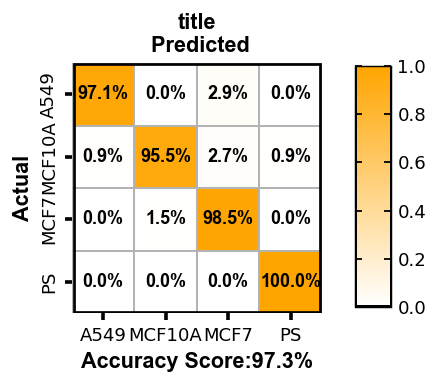

In [586]:
conf_mat_heatmap(clf_result['confmat_train'], rect_set3, 'title', cmap='5imp')

C:\Users\DELL\AppData\Local\Temp\ipykernel_5676\2762760416.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(curr_label, rotation=0, fontsize=10)


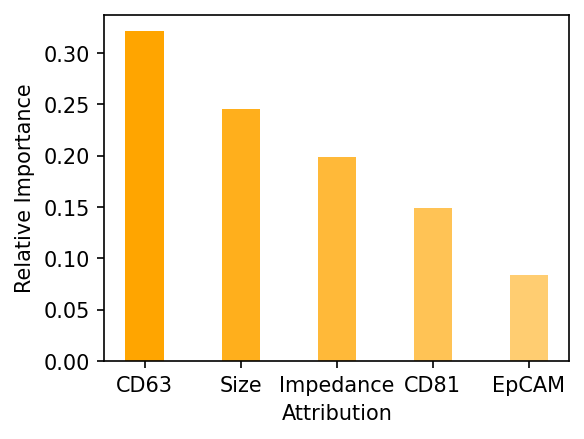

In [684]:
draw_impo(clf_result['feature_importance'], cmap='5imp')

In [12]:
draw_selected_confmat(result_rf, 10, name=['Training Set','Test Set'], impo=True, cmap=None)

# moving_average with DNN
## func

In [9]:
import tensorflow as tf

In [10]:
def create_model(input_shape=(5), output=4, **Dense_config):
    #Dense_config['Dense']: neurons in each layer, eg. [30,20,10]
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape)) #InputLayer, shape(None, 5)
    for neurons in Dense_config['Dense']:
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(output, activation='softmax'))
    return model
#model.get_config()
#model.summary()
#model.save("my_model.h5") #save as HDF5
#model = tf.keras.models.load_model("my_model.h5")

In [11]:
def run_model(model, data_mov, lr_0=0.001, file_name='layer', early_stopp=True, epochs=1000,
              root_dir=os.path.join(os.getcwd(), "export_data\DNN_model_save"),):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_0, ), #decay=0.01,lr=lr_0/(1+decay*iteration)
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'], steps_per_execution=10)
    run_id = time.strftime("%Y_%m_%d_%H_%M_%S_")
    log_dir = os.path.join(root_dir, run_id+file_name+'_lr'+str(lr_0))
    output_model_file = os.path.join(log_dir, 'best_model.h5')
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=output_model_file, save_best_only=True) #save only when best testset
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=2) # Enable histogram computation with each epoch.
    if early_stopp == True:
        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=50, min_delta=1e-4, restore_best_weights=True) #roll back to bset model
        callbacks=[tensorboard_callback, checkpoint_cb, early_stopping_cb]
    elif early_stopp == False:
        callbacks=[tensorboard_callback, checkpoint_cb]
    df_train_x, df_train_y, df_test_x, df_test_y = split_train_test(data_mov, y_col='type_num', split_y=True)
    history = model.fit(x=df_train_x, y=df_train_y,
                        epochs=epochs, verbose=1,
                        validation_data=(df_test_x, df_test_y),
                        callbacks=callbacks)
    return history

In [790]:
data_mov = moving_avg(df_import['size+imp+3Ab'], n=10, skip='PS', random_state=42)#5imp
data_mov['type_num'] = [type_2_num[i] for i in data_mov['type']]

temp = data_mov.loc[:,['type_num','type']].copy(deep=True)
df_drop = data_mov.drop(columns=['type_num','type'])
df_normalized = MinMaxScaler((0,1)).fit_transform(df_drop)
df_processed = pd.DataFrame(df_normalized, columns=df_drop.columns, index=df_drop.index)
df_avg_norm = pd.concat([df_processed, temp], axis=1)

df_train_x, df_train_y, df_test_x, df_test_y = split_train_test(data_mov, y_col='type_num', split_y=True)

In [8]:
model_ = create_model(input_shape=(5), output=4, Dense=[30,10,5])
root_dir=os.path.join(os.getcwd(), "export_data\DNN_model_save")
run_id = time.strftime("%Y_%m_%d_%H_%M_%S")
history_ = run_model(model_, df_avg_norm, lr_0=0.001, file_name='size+imp+3Ab_layer5_30_10_5', 
                     early_stopp=False, root_dir=root_dir, epochs=1000)

train_hist_ = pd.DataFrame(history_.history)
train_hist_.to_excel(os.path.join(root_dir, run_id+'size+imp+3Ab_layer5_30_10_5_lr0.001.xlsx'))

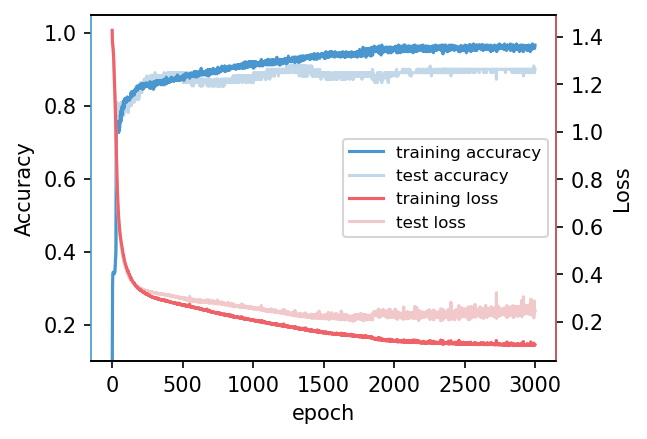

In [854]:
fig, ax1 = plt.subplots(figsize=(4,3), dpi=150)
cmap=sns.diverging_palette(240, 10, s=80, l=60, sep=20, n=4)
ax1.set_xlabel('epoch')
te_a, = ax1.plot(train_hist_.index, train_hist_['val_accuracy'], color=cmap[1], label='test accuracy')
tr_a, = ax1.plot(train_hist_.index, train_hist_['accuracy'], color=cmap[0], label='training accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.1,1.05])
ax1.spines["left"].set_color(cmap[0])

ax2 = ax1.twinx()
te_l, = ax2.plot(train_hist_.index, train_hist_['val_loss'], color=cmap[2], label='test loss')
tr_l, = ax2.plot(train_hist_.index, train_hist_['loss'], color=cmap[3], label='training loss')
ax2.set_ylabel('Loss')
#ax2.set_ylim([0,1.6])
ax2.spines["right"].set_color(cmap[3])
ax2.spines["left"].set_visible(False)

plt.legend(handles=[tr_a, te_a, tr_l, te_l], loc='center right', fontsize=8)

Note:  
training: average of each epoch; test: on the end of each epoch

## run_func

In [334]:
type_2_num={'A549':0, 'MCF10A':1, 'MCF7':2, 'PS':3}
def movingavg_with_DNN(data_dict, n_range, lr_0=0.001, Dense=[30,10,5], skip_mov='PS', skip_norm='5imp', random_state=42,
                      early_stopp=True, root_dir=os.path.join(os.getcwd(), "export_data\DNN_model_save")):
    accu_train = pd.DataFrame(np.zeros([len(n_range),len(data_dict)]), index = n_range, columns = data_dict.keys())
    loss_train = pd.DataFrame(np.zeros([len(n_range),len(data_dict)]), index = n_range, columns = data_dict.keys())
    accu_test = pd.DataFrame(np.zeros([len(n_range),len(data_dict)]), index = n_range, columns = data_dict.keys()) #accuracy of test set
    loss_test = pd.DataFrame(np.zeros([len(n_range),len(data_dict)]), index = n_range, columns = data_dict.keys()) #loss of test set
    run_history = {}
    for key in data_dict:
        history_n = []
        for n in n_range:
            data_mov = moving_avg(data_dict[key], n=n, skip=skip_mov, random_state=random_state)
            data_mov['type_num'] = [type_2_num[i] for i in data_mov['type']]
            if key != skip_norm:
                temp = data_mov.loc[:,['type_num','type']].copy(deep=True)
                df_drop = data_mov.drop(columns=['type_num','type'])
                df_normalized = MinMaxScaler((0,1)).fit_transform(df_drop)
                df_processed = pd.DataFrame(df_normalized, columns=df_drop.columns, index=df_drop.index)
                df_avg_norm = pd.concat([df_processed, temp], axis=1)
            else:
                df_avg_norm = data_mov.copy(deep=True)
            model = create_model(input_shape=df_avg_norm.shape[1]-2, output=len(df_avg_norm['type'].unique()), Dense=Dense)
            history = run_model(model, df_avg_norm, lr_0=lr_0, file_name=key+'_n='+str(n), 
                                early_stopp=early_stopp, root_dir=root_dir)
            history_n += [history]
            accu_train.loc[n, key] = history.history['accuracy'][-1]
            accu_test.loc[n, key] = history.history['val_accuracy'][-1]
            loss_train.loc[n, key] = history.history['loss'][-1]
            loss_test.loc[n, key] = history.history['val_loss'][-1]
        run_history[key] = history_n
    return accu_train, accu_test, loss_train, loss_test, run_history

In [1]:
root_dir=os.path.join(os.getcwd(), "export_data\DNN_model_save")
accu_train, accu_test, loss_train, loss_test, run_history = movingavg_with_DNN(df_import, n_range=range(1,21), lr_0=0.002, Dense=[30,10,5], 
                                                                               skip_mov='PS', skip_norm='5imp', random_state=42, 
                                                                               root_dir=root_dir)